# Aplicação do modelo ARIMA para detecção de outliers no tempo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

# Carrega a base de dados preparada anteriormente
df = pd.read_csv('sigesguarda_outlier.csv')
df.head(10)

,dataHora,data,ano,mes,mesNome,semana,dia,diaSemana,tipoDia,horario,hora,periodoDia,bairro,regiao,ocorrencia
0,2009-01-01 15:22:00,2009-01-01,2009,1,janeiro,s1,1,quinta,dia útil,15:22:00,15,tarde,fazendinha,fazendinha portão,roubo
1,2009-01-01 14:20:00,2009-01-01,2009,1,janeiro,s1,1,quinta,dia útil,14:20:00,14,tarde,centro,matriz,roubo
2,2009-01-02 00:58:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,00:58:00,0,madrugada,capão raso,pinheirinho,roubo
3,2009-01-02 00:21:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,00:21:00,0,madrugada,novo mundo,fazendinha portão,dano
4,2009-01-02 12:40:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,12:40:00,12,tarde,centro,matriz,roubo
5,2009-01-02 14:05:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,14:05:00,14,tarde,barreirinha,boa vista,dano
6,2009-01-05 15:25:00,2009-01-05,2009,1,janeiro,s1,5,segunda,dia útil,15:25:00,15,tarde,cidade industrial,cic,roubo
7,2009-01-02 15:00:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,15:00:00,15,tarde,centro,matriz,furto
8,2009-01-02 15:15:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,15:15:00,15,tarde,santa felicidade,santa felicidade,dano
9,2009-01-02 21:25:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,21:25:00,21,noite,cajuru,cajuru,dano


## Preparação adicional dos dados

In [2]:
# Converte as colunas para os dados corretor
df['data'] = pd.to_datetime(df['data'])
df['dataHora'] = pd.to_datetime(df['dataHora'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78510 entries, 0 to 78509
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dataHora    78510 non-null  datetime64[ns]
 1   data        78510 non-null  datetime64[ns]
 2   ano         78510 non-null  int64         
 3   mes         78510 non-null  int64         
 4   mesNome     78510 non-null  object        
 5   semana      78510 non-null  object        
 6   dia         78510 non-null  int64         
 7   diaSemana   78510 non-null  object        
 8   tipoDia     78510 non-null  object        
 9   horario     78510 non-null  object        
 10  hora        78510 non-null  int64         
 11  periodoDia  78510 non-null  object        
 12  bairro      78510 non-null  object        
 13  regiao      78510 non-null  object        
 14  ocorrencia  78510 non-null  object        
dtypes: datetime64[ns](2), int64(4), object(9)
memory usage: 9.0+ MB


In [3]:
# Cria um novo data frame contendo a data e sua a contagem total de ocorrências criminais
df_group = df.groupby('data').size().reset_index(name='count')
df_group.set_index('data', inplace=True)
df_group

,count
data,
2009-01-01,2
2009-01-02,9
2009-01-03,8
2009-01-04,28
2009-01-05,10
...,...
2022-12-08,15
2022-12-09,13
2022-12-10,19


In [4]:
# Cria um novo dataframe contendo a população estimada de Curitiba por ano
df_pop = pd.read_csv('populacao_estimada_curitiba.csv')
df_pop = df_pop[['ano', 'populacao_estimada']]
df_pop.head(10)

,ano,populacao_estimada
0,2001,1620219
1,2002,1644600
2,2003,1671194
3,2004,1727010
4,2005,1757904
5,2006,1788559
6,2007,1788559
7,2008,1828095
8,2009,1851215
9,2010,1851215


In [5]:
df_group = df_group.reset_index(drop=False)
df_group

,data,count
0,2009-01-01,2
1,2009-01-02,9
2,2009-01-03,8
3,2009-01-04,28
4,2009-01-05,10
...,...,...
5088,2022-12-08,15
5089,2022-12-09,13
5090,2022-12-10,19
5091,2022-12-11,16


In [6]:
# Extrai apenas o ano da coluna 'data' e adiciona em uma nova coluna
df_group['ano'] = df_group['data'].dt.year
df_group

,data,count,ano
0,2009-01-01,2,2009
1,2009-01-02,9,2009
2,2009-01-03,8,2009
3,2009-01-04,28,2009
4,2009-01-05,10,2009
...,...,...,...
5088,2022-12-08,15,2022
5089,2022-12-09,13,2022
5090,2022-12-10,19,2022
5091,2022-12-11,16,2022


In [7]:
# Faz o merge dos dataframes para que para cada da base de dados esteja associado a população estimada daquele ano
df_group = pd.merge(df_group, df_pop, on='ano', how='inner')
df_group

,data,count,ano,populacao_estimada
0,2009-01-01,2,2009,1851215
1,2009-01-02,9,2009,1851215
2,2009-01-03,8,2009,1851215
3,2009-01-04,28,2009,1851215
4,2009-01-05,10,2009,1851215
...,...,...,...,...
5088,2022-12-08,15,2022,1963726
5089,2022-12-09,13,2022,1963726
5090,2022-12-10,19,2022,1963726
5091,2022-12-11,16,2022,1963726


In [8]:
# Adiciona a data com índice do data frame
df_group.set_index('data', inplace=True)
df_group

,count,ano,populacao_estimada
data,,,
2009-01-01,2,2009,1851215
2009-01-02,9,2009,1851215
2009-01-03,8,2009,1851215
2009-01-04,28,2009,1851215
2009-01-05,10,2009,1851215
...,...,...,...
2022-12-08,15,2022,1963726
2022-12-09,13,2022,1963726
2022-12-10,19,2022,1963726


In [9]:
# Realiza a normalização dos dados indicando o total de ocorrências por dia dividido pela população estimada daquele ano
df_group['count_por_pop'] = df_group['count'] / df_group['populacao_estimada']
df_group

,count,ano,populacao_estimada,count_por_pop
data,,,,
2009-01-01,2,2009,1851215,0.000001
2009-01-02,9,2009,1851215,0.000005
2009-01-03,8,2009,1851215,0.000004
2009-01-04,28,2009,1851215,0.000015
2009-01-05,10,2009,1851215,0.000005
...,...,...,...,...
2022-12-08,15,2022,1963726,0.000008
2022-12-09,13,2022,1963726,0.000007
2022-12-10,19,2022,1963726,0.000010


## Aplciação do modelo ARIMA para dados temporais

C:\Users\breno\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\breno\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\breno\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\breno\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


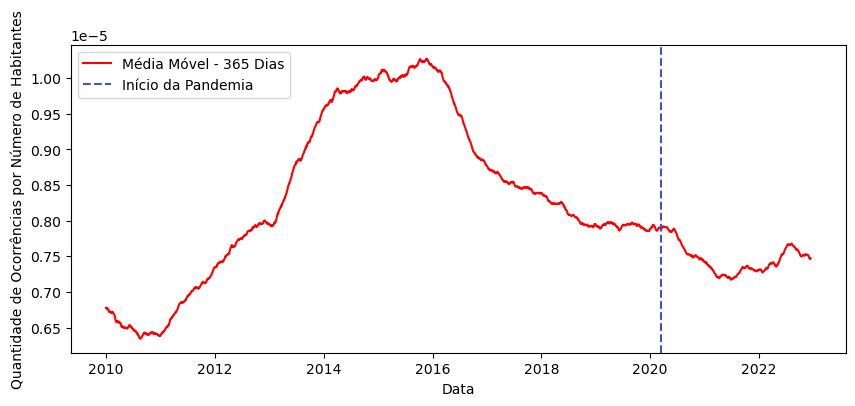

In [13]:
# Aplicação do modelo ARIMA

# Inicializa o modelo utilizando os valores de p, d, q como 7, 0, 2
model = ARIMA(df_group['count_por_pop'], order=(7, 0, 2))
model_fit = model.fit()

# Treina o modelo para realizar as predições com base no número de ocorrências por dia
predictions = model_fit.predict(df_group.index[0], end=df_group.index[-1])

# Cria uma janela de 365 dias para a média móvel
window = 365

# Calcula a média móvel para analisar a tendência  utilizando uma janela de 365 dias
moving_average = predictions.rolling(window).mean()

# Data do início oficial da pandemia de COVID-19
target_date = '2020-03-11'
target_date = pd.to_datetime(target_date)

# Plota o gráfico da média móvel onde a linha pontilhada indica o início da pandemia de COVID-19
plt.figure(figsize=(10, 4))
plt.plot(moving_average, color='red', label=f'Média Móvel - {window} Dias')
plt.axvline(x=target_date, color='#4154b0', linestyle='--', label='Início da Pandemia')
plt.xlabel('Data')
plt.ylabel('Quantidade de Ocorrências por Número de Habitantes')
plt.legend()

Text(0.5, 1.0, 'Residual Scatterplot')

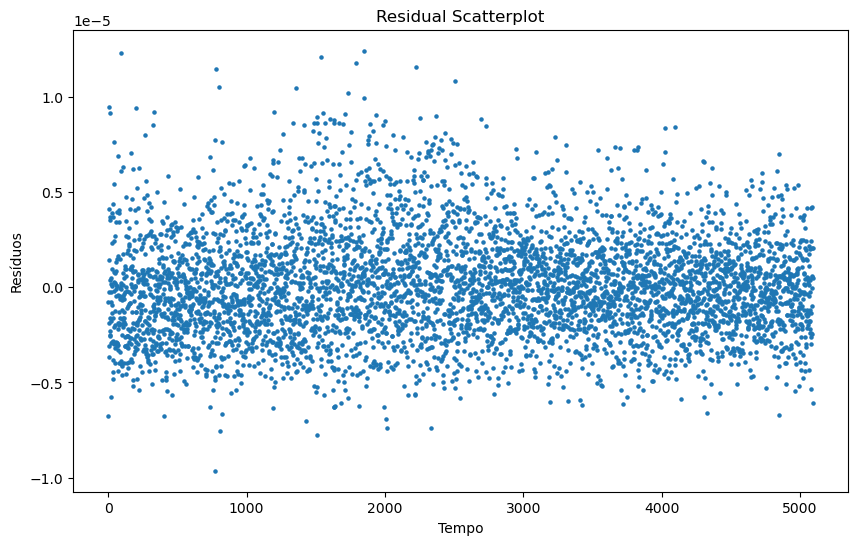

In [14]:
# Cria o mapa de resíduos que indicam a distância de cada instânica com o valor previsto pelo modelo
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, s=5)
plt.xlabel('Tempo')
plt.ylabel('Resíduos')
plt.title('Residual Scatterplot')

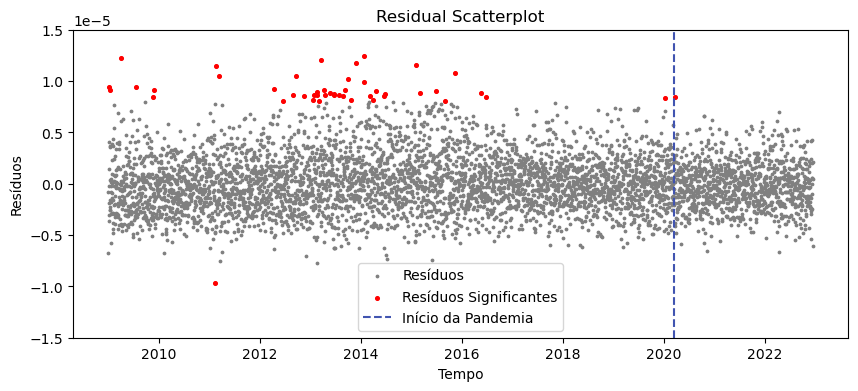

In [15]:
# Isola os resíduos com uma distância significante do valor da predição, que indicam dias quando ocorreu um número anômalo de ocorrências
# As intâncias normais são pintadas de cinza e as anômalos em vermelho
significant_residuals = residuals[(residuals > 0.000008) | (residuals < -0.000008)]
plt.figure(figsize=(10, 4))
plt.scatter(residuals.index, residuals, color='gray', label='Resíduos', s=3)
plt.scatter(significant_residuals.index, significant_residuals, color='red', label='Resíduos Significantes', s=7)
plt.axvline(x=target_date, color='#4154b0', linestyle='--', label='Início da Pandemia')
plt.xlabel('Tempo')
plt.ylabel('Resíduos')
plt.title('Residual Scatterplot')
plt.ylim(-0.000015, 0.000015)
plt.legend()